# TOI 519 TESS light curve overview

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [80]:
from astropy.table import Table
from pytransit.utils.misc import fold
from pytransit.lpf import BaseLPF
from pytransit.lpf.tesslpf import TESSLPF, downsample_time
from muscat2ph.catalog import get_toi
from astropy.io.fits import getval

In [ ]:
def plot_folded_transit(self, method='de', figsize=(13, 6), ylim=(0.9975, 1.002), xlim=None, binwidth=8):
    if method == 'de':
        pv = self.de.minimum_location
        tc, p = pv[[0, 1]]
    else:
        raise NotImplementedError

    phase = p * fold(self.timea, p, tc, 0.5)
    binwidth = binwidth / 24 / 60
    sids = argsort(phase)

    tm = self.transit_model(pv)
    bl = squeeze(self.baseline(pv))

    bp, bfo, beo = downsample_time(phase[sids], (self.ofluxa / bl)[sids], binwidth)

    fig, ax = subplots(figsize=figsize)
    ax.plot(phase - 0.5 * p, self.ofluxa / bl, '.', alpha=0.15)
    ax.errorbar(bp - 0.5 * p, bfo, beo, fmt='ko')
    ax.plot(phase[sids] - 0.5 * p, tm[sids], 'k')
    xlim = xlim if xlim is not None else 1.01 * (bp[isfinite(bp)][[0, -1]] - 0.5 * p)
    setp(ax, ylim=ylim, xlim=xlim, xlabel='Time - Tc [d]', ylabel='Normalised flux')
    fig.tight_layout()

In [7]:
toi = get_toi(519.01)

In [50]:
fname = 'photometry/tess2019006130736-s0007-0000000218795833-0131-s_lc.fits'

In [51]:
df = Table.read(fname).to_pandas()

In [52]:
tref = getval(fname, 'bjdrefi', 1)

In [55]:
m = isfinite(df.TIME.values) & isfinite(df.PDCSAP_FLUX.values)
time = df.TIME.values[m].astype('d')
flux = df.PDCSAP_FLUX.values[m].astype('d') / nanmedian(df.PDCSAP_FLUX)

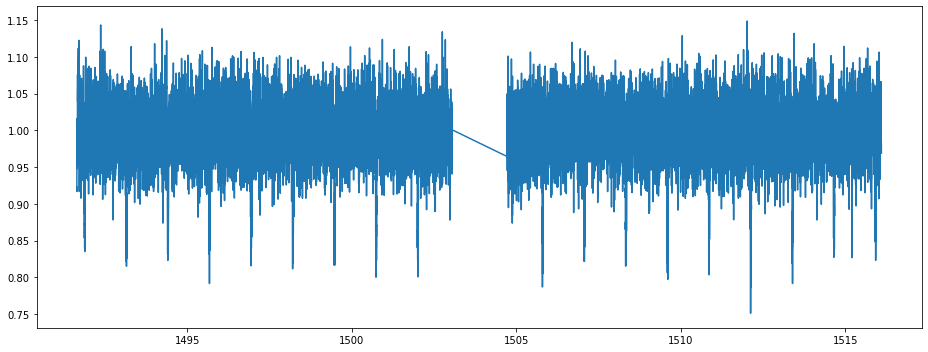

In [56]:
fig, ax = subplots(figsize=(13,5)) 
ax.plot(time, flux)
fig.tight_layout()

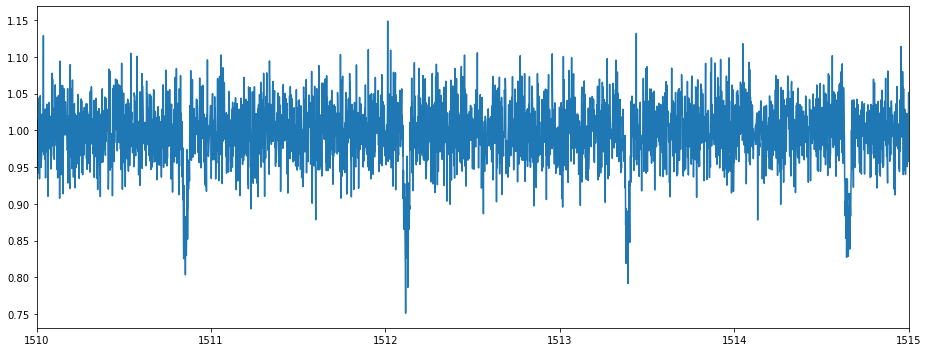

In [11]:
fig, ax = subplots(figsize=(13,5)) 
ax.plot(time, flux)
xlim(1510,1515)
fig.tight_layout()

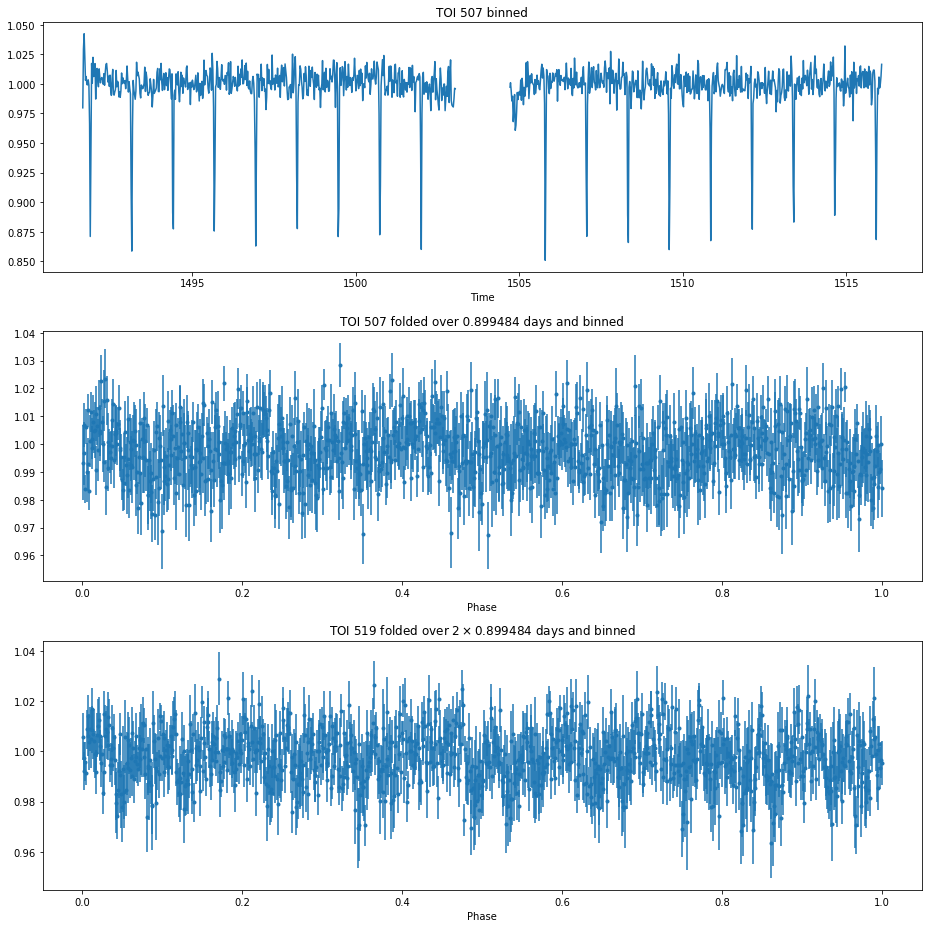

In [221]:
fig, axs = subplots(3,1, figsize=(13,13))
bt, bf, be = downsample_time(time, flux, 1/(2*24))
axs[0].plot(bt, bf)
setp(axs[0], title='TOI 507 binned', xlabel='Time')

phase = fold(time, 0.899485, 0.3)
sids = argsort(phase)
bp, bf, be = downsample_time(phase[sids], flux[sids], 0.001)
axs[1].errorbar(bp, bf, be, fmt='.')
setp(axs[1], title='TOI 507 folded over 0.899484 days and binned', xlabel='Phase')


phase = fold(time, 2*0.899485, 0.3)
sids = argsort(phase)
bp, bf, be = downsample_time(phase[sids], flux[sids], 0.001)
axs[2].errorbar(bp, bf, be, fmt='.')
setp(axs[2], title=r'TOI 519 folded over $2\times 0.899484$ days and binned', xlabel='Phase')

fig.tight_layout()
fig.savefig('tess_lc.pdf')

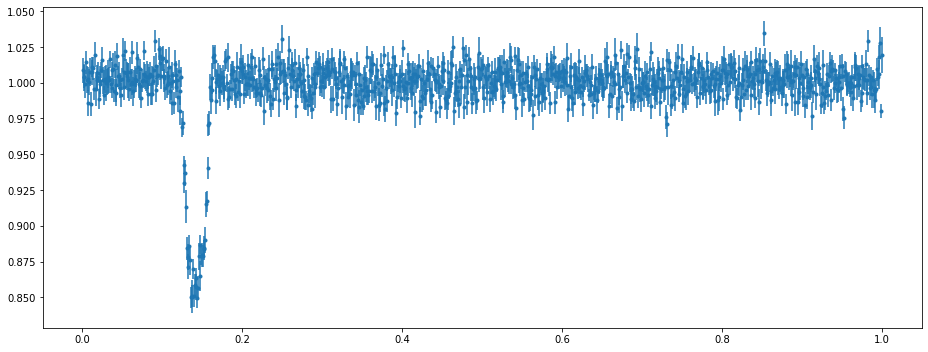

In [12]:
fig, ax = subplots(figsize=(13,5)) 
phase = fold(time, toi.period[0], 0)
sids = argsort(phase)
bp, bf, be = downsample_time(phase[sids], flux[sids], 0.001)
ax.errorbar(bp, bf, be, fmt='.')
fig.tight_layout()

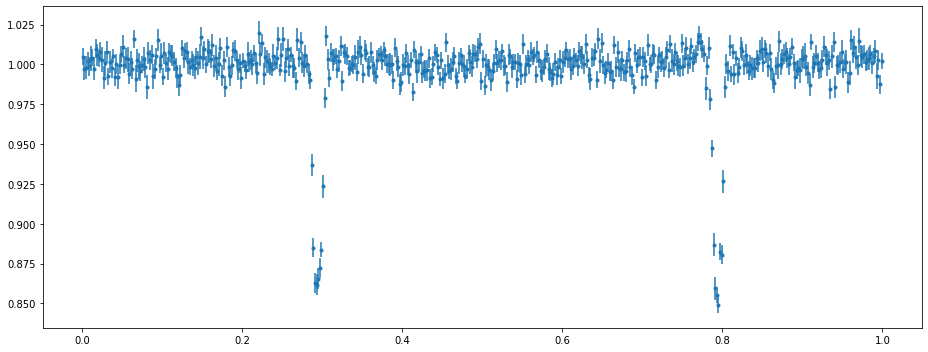

In [19]:
fig, ax = subplots(figsize=(13,5)) 
phase = fold(time, 2*toi.period[0], 0.7)
sids = argsort(phase)
bp, bf, be = downsample_time(phase[sids], flux[sids], 0.002)
ax.errorbar(bp, bf, be, fmt='.')
fig.tight_layout()

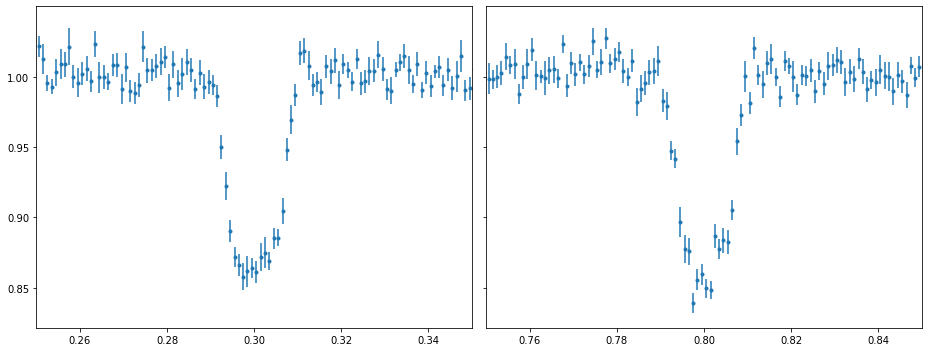

In [27]:
fig, axs = subplots(1, 2, figsize=(13,5), sharey='all') 
phase = fold(time, 2*toi.period[0], 0.685)
sids = argsort(phase)
bp, bf, be = downsample_time(phase[sids], flux[sids], 0.001)
axs[0].errorbar(bp, bf, be, fmt='.')
axs[1].errorbar(bp, bf, be, fmt='.')
setp(axs[0], xlim=(0.25,0.35))
setp(axs[1], xlim=(0.75,0.85))
fig.tight_layout()

In [207]:
phase1 = fold(time, 2*toi.period[0], toi.epoch[0]-tref, 0.5) - 0.5
phase2 = fold(time, 2*toi.period[0], toi.epoch[0]-tref) - 0.5
pmask1 = abs(phase1) < 0.035
pmask2 = abs(phase2) < 0.035

lpf1 = BaseLPF('TOI_519_a', ['T'], time[pmask1], flux[pmask1])
lpf2 = BaseLPF('TOI_519_b', ['T'], time[pmask2], flux[pmask2])

lpf1.set_prior('tc', 'NP', toi.epoch[0]-tref, 0.01)
lpf2.set_prior('tc', 'NP', toi.epoch[0]-tref + toi.period[0], 0.01)

for lpf in (lpf1, lpf2):
    lpf.set_prior('p', 'NP', 2*toi.period[0], 10*toi.period[1])
    lpf.set_prior('rho', 'UP', 5, 50)
    lpf.set_prior('q1_0', 'NP', 0.26, 0.01)
    lpf.set_prior('q2_0', 'NP', 0.26, 0.01)
    lpf.set_radius_ratio_prior(0.1, 0.5)

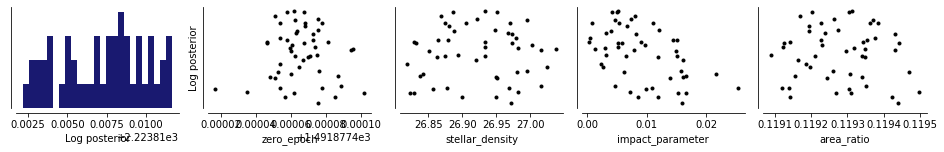

In [208]:
lpf1.optimize_global(500)

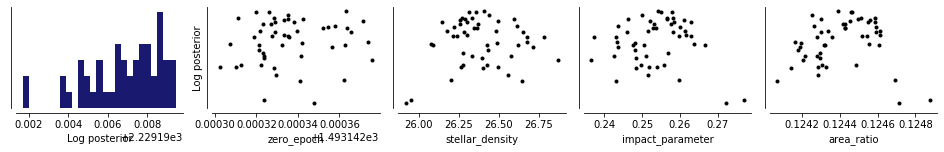

In [209]:
lpf2.optimize_global(500)

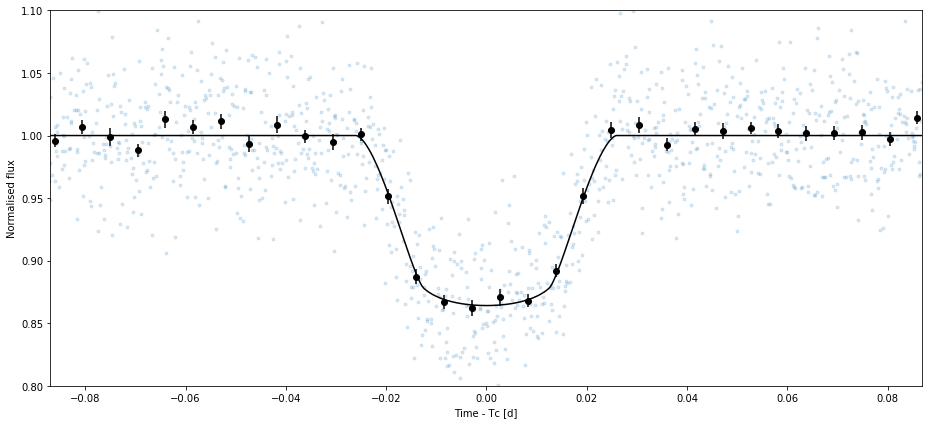

In [210]:
plot_folded_transit(lpf1, ylim=(0.8,1.1))

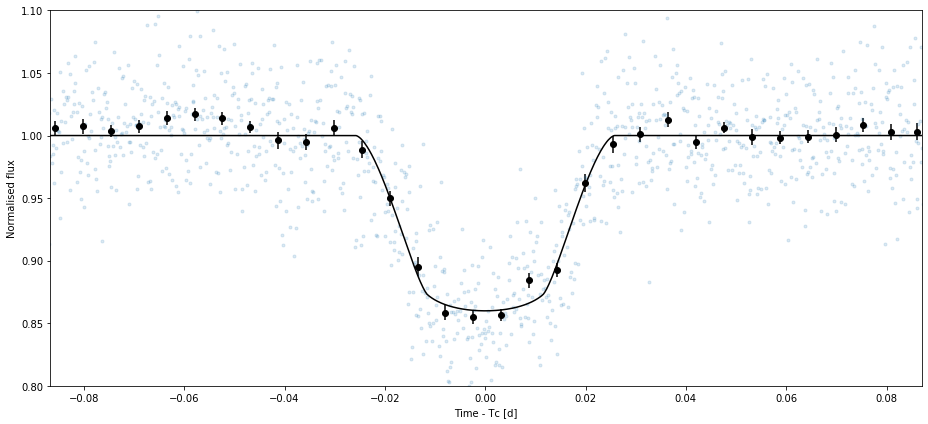

In [211]:
plot_folded_transit(lpf2, ylim=(0.8,1.1))

In [212]:
lpf1.sample_mcmc(500, thin=10, repeats=20)

In [213]:
lpf2.sample_mcmc(500, thin=10, repeats=20)

In [214]:
df1 = lpf1.posterior_samples()
df2 = lpf2.posterior_samples()

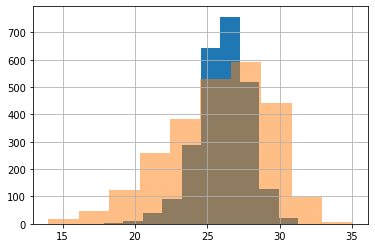

In [215]:
df1.rho.hist()
df2.rho.hist(alpha=0.5)

In [216]:
import seaborn as sb

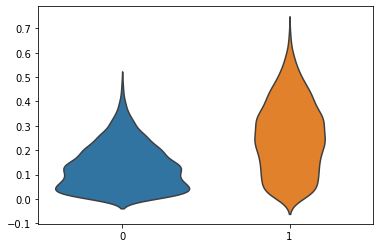

In [217]:
sb.violinplot(data=[df1.b,df2.b], inner=None)

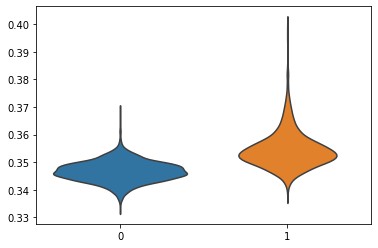

In [218]:
sb.violinplot(data=[df1.k,df2.k], inner=None)

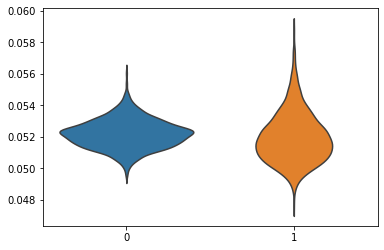

In [219]:
sb.violinplot(data=[df1.t14,df2.t14], inner=None)